# Anomaly Detection - Isolation Forests

### Data Mining Project 2024/25

Authors: Nicola Emmolo, Simone Marzeddu, Jacopo Raffi

In [1]:
from sklearn.ensemble import IsolationForest

import seaborn
from scipy.spatial.distance import pdist, squareform

import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

In [2]:
cyclists_dataset = pd.read_csv('../data/cyclists_dataset_fe.csv', dtype={'cyclist_team': str})
cyclists_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6095 entries, 0 to 6094
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cyclist_url      6095 non-null   object 
 1   mean_cyclist_cp  5011 non-null   float64
 2   mean_delta       6095 non-null   float64
 3   mean_position    6095 non-null   float64
 4   birth_year       6095 non-null   int64  
 5   weight           3134 non-null   float64
 6   height           3134 non-null   float64
 7   nationality      6095 non-null   object 
 8   cyclist_name     6095 non-null   object 
 9   cyclist_bmi      3134 non-null   float64
dtypes: float64(6), int64(1), object(3)
memory usage: 476.3+ KB


In [3]:
races_dataset = pd.read_csv('../data/races_dataset_fe.csv')
races_dataset['date'] = pd.to_datetime(races_dataset['date'], format='%Y-%m-%d')
races_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5281 entries, 0 to 5280
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   race_url              5281 non-null   object        
 1   race_name             5281 non-null   object        
 2   points                5281 non-null   float64       
 3   uci_points            2780 non-null   float64       
 4   length                5281 non-null   float64       
 5   climb_total           3326 non-null   float64       
 6   profile               3326 non-null   float64       
 7   startlist_quality     5281 non-null   int64         
 8   date                  5281 non-null   datetime64[ns]
 9   mostly_tarmac         5281 non-null   bool          
 10  race_year             5281 non-null   int64         
 11  race_stage            5281 non-null   object        
 12  race_season           5281 non-null   object        
 13  climb_percentage  

In [4]:
complete_dataset = pd.read_csv('../data/complete_dataset_fe.csv', dtype={'cyclist_team': str})
complete_dataset['date'] = pd.to_datetime(complete_dataset['date'], format='%Y-%m-%d')
complete_dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589739 entries, 0 to 589738
Data columns (total 37 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   cyclist_url                  589739 non-null  object        
 1   cyclist_name                 589739 non-null  object        
 2   birth_year                   589739 non-null  int64         
 3   weight                       480007 non-null  float64       
 4   height                       480007 non-null  float64       
 5   nationality                  589739 non-null  object        
 6   race_url                     589739 non-null  object        
 7   race_name                    589739 non-null  object        
 8   points                       589739 non-null  float64       
 9   uci_points                   422184 non-null  float64       
 10  length                       589739 non-null  float64       
 11  climb_total               

## Anomaly Detection - Cyclists Dataset

<Axes: >

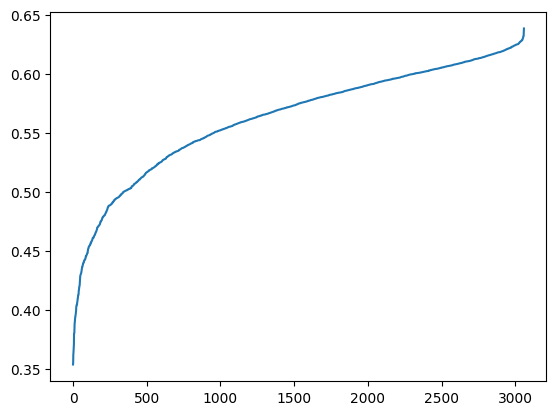

In [5]:
# Filter the dataset to keep only numeric and non-NaN rows
numeric_dataset = cyclists_dataset.select_dtypes(include=['number'])
numeric_dataset = numeric_dataset.dropna()

max_features = numeric_dataset.shape[1]
algorithm = IsolationForest(max_features=max_features)
algorithm.fit(numeric_dataset)

# Calculate outlier degrees and scores
outlier_degrees = algorithm.decision_function(numeric_dataset) + 0.5
outlier_scores = 1 - (algorithm.predict(numeric_dataset) + 1) / 2

# Combine with original dataset
dataset_with_outlier_scores = cyclists_dataset.copy()

# Initialize the new columns with NaN to match the original dataset's length
dataset_with_outlier_scores["isolation_forest_degree"] = float("nan")
dataset_with_outlier_scores["isolation_forest_scores"] = float("nan")

# Assign outlier scores only to the rows used in numeric_dataset
dataset_with_outlier_scores.loc[numeric_dataset.index, "isolation_forest_degree"] = outlier_degrees
dataset_with_outlier_scores.loc[numeric_dataset.index, "isolation_forest_scores"] = outlier_scores

# Plot sorted outlier degrees, with x matching its length
sorted_outlier_degrees = sorted(outlier_degrees)

seaborn.lineplot(
    x=range(len(sorted_outlier_degrees)),  # x-axis matches the length of sorted_outlier_degrees
    y=sorted_outlier_degrees
)

The outlier_degrees array provides a measure of how far each sample is from the decision boundary (the value is normalized):
- Close to 1: More likely to be an inlier.
- Close to 0: More likely to be an outlier.


The outlier_scores array represents a "binarized likelihood" of each data point being an outlier (scores values are 0 or 1):
- 1: More likely to be an outlier.
- 0: More likely to be an inlier.

In [6]:
degree_threshold = 0.45

# Combine thresholds for outlier detection
dataset_with_outlier_scores["is_outlier"] = (
    (dataset_with_outlier_scores["isolation_forest_scores"] == 1) &
    (dataset_with_outlier_scores["isolation_forest_degree"] < degree_threshold)
)

len(dataset_with_outlier_scores[dataset_with_outlier_scores["is_outlier"] == 1])

101

In [7]:
anomalies = dataset_with_outlier_scores[dataset_with_outlier_scores["is_outlier"] == 1]

anomalies.describe()

,mean_cyclist_cp,mean_delta,mean_position,birth_year,weight,height,cyclist_bmi,isolation_forest_degree,isolation_forest_scores
count,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.0
mean,0.020376,598.994241,0.565974,1972.801980,70.861386,178.683168,22.130764,0.420149,1.0
std,0.030638,837.335233,0.236329,19.398464,11.054981,10.922390,2.356813,0.024900,0.0
min,0.000002,3.000000,0.044118,1940.000000,48.000000,154.000000,16.412069,0.353731,1.0
25%,0.000353,174.210526,0.389196,1952.000000,62.000000,170.000000,20.459135,0.403898,1.0
50%,0.001844,402.076246,0.543702,1980.000000,72.000000,180.000000,22.308150,0.429220,1.0
75%,0.034930,794.273786,0.755218,1986.000000,79.000000,187.000000,23.668639,0.441725,1.0
max,0.107286,7291.800000,1.000000,2003.000000,94.000000,204.000000,27.770313,0.449958,1.0


In [8]:
# The outliers found are now filtered from the dataset
dataset_with_outlier_scores = dataset_with_outlier_scores[dataset_with_outlier_scores['is_outlier'] != 1]

# Remove specified columns (used just during computation and analysis)
columns_to_remove = ['isolation_forest_scores', 'isolation_forest_degree', 'is_outlier']
final_dataset = dataset_with_outlier_scores.drop(columns=columns_to_remove)

# The dataset is now saved in csv format
final_dataset.to_csv('../data/cyclists_dataset_no_outliers.csv', index=False)

## Anomaly Detection - Races Dataset

<Axes: >

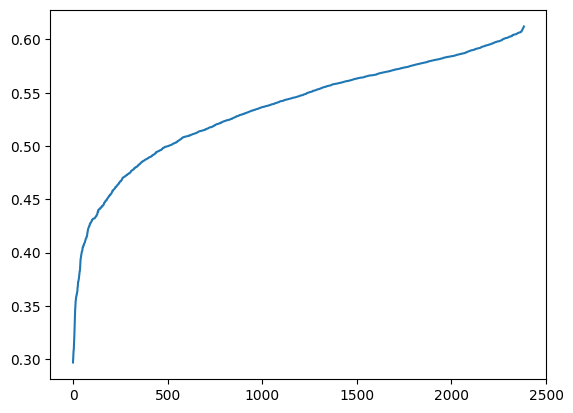

In [9]:
# Filter the dataset to keep only numeric and non-NaN rows
numeric_dataset = races_dataset.select_dtypes(include=['number'])
numeric_dataset = numeric_dataset.dropna()

max_features = numeric_dataset.shape[1]
algorithm = IsolationForest(max_features=max_features)
algorithm.fit(numeric_dataset)

# Calculate outlier degrees and scores
outlier_degrees = algorithm.decision_function(numeric_dataset) + 0.5
outlier_scores = 1 - (algorithm.predict(numeric_dataset) + 1) / 2

# Combine with original dataset
dataset_with_outlier_scores = races_dataset.copy()

# Initialize the new columns with NaN to match the original dataset's length
dataset_with_outlier_scores["isolation_forest_degree"] = float("nan")
dataset_with_outlier_scores["isolation_forest_scores"] = float("nan")

# Assign outlier scores only to the rows used in numeric_dataset
dataset_with_outlier_scores.loc[numeric_dataset.index, "isolation_forest_degree"] = outlier_degrees
dataset_with_outlier_scores.loc[numeric_dataset.index, "isolation_forest_scores"] = outlier_scores

# Plot sorted outlier degrees, with x matching its length
sorted_outlier_degrees = sorted(outlier_degrees)

seaborn.lineplot(
    x=range(len(sorted_outlier_degrees)),  # x-axis matches the length of sorted_outlier_degrees
    y=sorted_outlier_degrees
)

The outlier_degrees array provides a measure of how far each sample is from the decision boundary (the value is normalized):
- Close to 1: More likely to be an inlier.
- Close to 0: More likely to be an outlier.


The outlier_scores array represents a "binarized likelihood" of each data point being an outlier (scores values are 0 or 1):
- 1: More likely to be an outlier.
- 0: More likely to be an inlier.

In [10]:
degree_threshold = 0.45

# Combine thresholds for outlier detection
dataset_with_outlier_scores["is_outlier"] = (
    (dataset_with_outlier_scores["isolation_forest_scores"] == 1) &
    (dataset_with_outlier_scores["isolation_forest_degree"] < degree_threshold)
)

len(dataset_with_outlier_scores[dataset_with_outlier_scores["is_outlier"] == 1])

180

In [11]:
anomalies = dataset_with_outlier_scores[dataset_with_outlier_scores["is_outlier"] == 1]

anomalies.describe()

,points,uci_points,length,climb_total,profile,startlist_quality,date,race_year,climb_percentage,race_physical_effort,race_prestige,isolation_forest_degree,isolation_forest_scores
count,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180,180.000000,180.000000,180.000000,180.000000,180.000000,180.0
mean,204.611111,353.277778,194.805222,3.000922,2.855556,1039.800000,2011-07-17 20:00:00,2011.083333,0.045689,0.224333,0.340100,0.412188,1.0
min,20.000000,6.000000,1.900000,0.021000,1.000000,156.000000,2001-03-31 00:00:00,2001.000000,0.000409,0.000030,0.000000,0.296877,1.0
25%,95.000000,51.250000,182.875000,1.330000,2.000000,810.500000,2005-04-17 12:00:00,2005.000000,0.007895,0.032567,0.162617,0.398750,1.0
50%,275.000000,500.000000,243.150000,3.085500,2.000000,1023.500000,2010-09-22 12:00:00,2010.000000,0.016796,0.147492,0.327543,0.426954,1.0
75%,275.000000,500.000000,259.000000,4.525500,5.000000,1227.500000,2017-07-31 06:00:00,2017.000000,0.028361,0.338087,0.470814,0.440035,1.0
max,350.000000,800.000000,305.000000,6.939000,5.000000,1812.000000,2023-07-19 00:00:00,2023.000000,0.981053,0.910685,0.908128,0.449744,1.0
std,107.036588,235.248830,97.233878,1.826152,1.561128,339.283675,NaN,6.984320,0.110963,0.233134,0.210331,0.036137,0.0


In [12]:
# The outliers found are now filtered from the dataset
dataset_with_outlier_scores = dataset_with_outlier_scores[dataset_with_outlier_scores['is_outlier'] != 1]

# Remove specified columns (used just during computation and analysis)
columns_to_remove = ['isolation_forest_scores', 'isolation_forest_degree', 'is_outlier']
final_dataset = dataset_with_outlier_scores.drop(columns=columns_to_remove)

# The dataset is now saved in csv format
final_dataset.to_csv('../data/races_dataset_no_outliers.csv', index=False)

## Anomaly Detection - Cyclist + Races Merged Dataset

<Axes: >

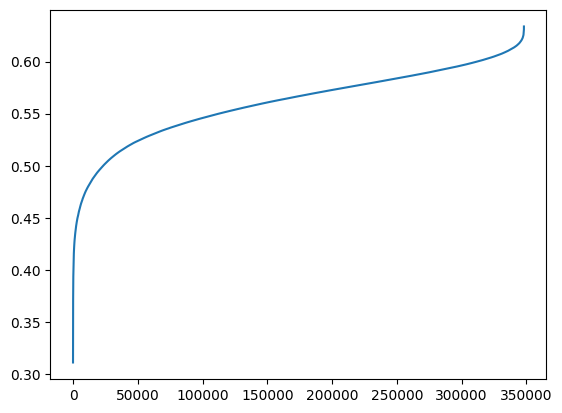

In [13]:
# Filter the dataset to keep only numeric and non-NaN rows
numeric_dataset = complete_dataset.select_dtypes(include=['number'])
numeric_dataset = numeric_dataset.dropna()

max_features = numeric_dataset.shape[1]
algorithm = IsolationForest(max_features=max_features)
algorithm.fit(numeric_dataset)

# Calculate outlier degrees and scores
outlier_degrees = algorithm.decision_function(numeric_dataset) + 0.5
outlier_scores = 1 - (algorithm.predict(numeric_dataset) + 1) / 2

# Combine with original dataset
dataset_with_outlier_scores = complete_dataset.copy()

# Initialize the new columns with NaN to match the original dataset's length
dataset_with_outlier_scores["isolation_forest_degree"] = float("nan")
dataset_with_outlier_scores["isolation_forest_scores"] = float("nan")

# Assign outlier scores only to the rows used in numeric_dataset
dataset_with_outlier_scores.loc[numeric_dataset.index, "isolation_forest_degree"] = outlier_degrees
dataset_with_outlier_scores.loc[numeric_dataset.index, "isolation_forest_scores"] = outlier_scores

# Plot sorted outlier degrees, with x matching its length
sorted_outlier_degrees = sorted(outlier_degrees)

seaborn.lineplot(
    x=range(len(sorted_outlier_degrees)),  # x-axis matches the length of sorted_outlier_degrees
    y=sorted_outlier_degrees
)

The outlier_degrees array provides a measure of how far each sample is from the decision boundary (the value is normalized):
- Close to 1: More likely to be an inlier.
- Close to 0: More likely to be an outlier.


The outlier_scores array represents a "binarized likelihood" of each data point being an outlier (scores values are 0 or 1):
- 1: More likely to be an outlier.
- 0: More likely to be an inlier.

In [14]:
degree_threshold = 0.45

# Combine thresholds for outlier detection
dataset_with_outlier_scores["is_outlier"] = (
    (dataset_with_outlier_scores["isolation_forest_scores"] == 1) &
    (dataset_with_outlier_scores["isolation_forest_degree"] < degree_threshold)
)

len(dataset_with_outlier_scores[dataset_with_outlier_scores["is_outlier"] == 1])

3485

In [15]:
anomalies = dataset_with_outlier_scores[dataset_with_outlier_scores["is_outlier"] == 1]

anomalies.describe()

,birth_year,weight,height,points,uci_points,length,climb_total,profile,startlist_quality,date,...,race_prestige,mean_cyclist_cp,mean_delta,mean_position,previous_mean_position,previous_mean_delta,previous_mean_cp,cyclist_previous_experience,isolation_forest_degree,isolation_forest_scores
count,3485.000000,3485.000000,3485.000000,3485.000000,3485.000000,3485.000000,3485.000000,3485.000000,3485.000000,3485,...,3485.000000,3485.000000,3485.000000,3485.000000,3485.000000,3485.000000,3485.000000,3485.000000,3485.000000,3485.0
mean,1983.533716,69.888723,180.359254,229.340029,389.725108,223.484531,3.202325,2.971879,1146.752654,2013-02-18 07:28:44.074605568,...,0.419944,0.022308,489.492752,0.437858,0.441493,514.738104,0.034938,0.349333,0.429262,1.0
min,1963.000000,48.000000,160.000000,20.000000,6.000000,1.900000,0.002000,1.000000,156.000000,2001-03-31 00:00:00,...,0.000000,0.000009,38.142857,0.102442,0.008065,0.000000,0.000005,0.000185,0.311053,1.0
25%,1979.000000,63.000000,175.000000,100.000000,60.000000,199.500000,2.060000,2.000000,920.000000,2008-07-13 00:00:00,...,0.258459,0.003524,192.015198,0.282142,0.282849,181.444444,0.002896,0.090668,0.422016,1.0
50%,1983.000000,70.000000,180.000000,275.000000,500.000000,254.100000,3.545000,2.000000,1130.000000,2012-09-29 00:00:00,...,0.418155,0.006994,402.076246,0.417459,0.420617,369.602151,0.007266,0.286241,0.435399,1.0
75%,1988.000000,76.000000,185.000000,350.000000,600.000000,261.000000,4.538000,5.000000,1347.000000,2018-03-17 00:00:00,...,0.616825,0.034930,684.460317,0.560263,0.561542,657.586957,0.050905,0.569211,0.443765,1.0
max,2004.000000,94.000000,204.000000,350.000000,800.000000,305.000000,6.939000,5.000000,1812.000000,2023-07-29 00:00:00,...,0.908128,0.107286,7291.800000,0.985353,0.990575,13027.500000,0.486024,1.000000,0.449996,1.0
std,7.713574,8.172305,7.142719,110.823077,249.282281,66.712684,1.525717,1.526953,298.402162,NaN,...,0.235679,0.027665,419.411458,0.187251,0.193101,645.243398,0.059641,0.287746,0.020605,0.0


In [16]:
# The outliers found are now filtered from the dataset
dataset_with_outlier_scores = dataset_with_outlier_scores[dataset_with_outlier_scores['is_outlier'] != 1]

# Remove specified columns (used just during computation and analysis)
columns_to_remove = ['isolation_forest_scores', 'isolation_forest_degree', 'is_outlier']
final_dataset = dataset_with_outlier_scores.drop(columns=columns_to_remove)

# The dataset is now saved in csv format
final_dataset.to_csv('../data/complete_dataset_no_outliers.csv', index=False)